## Aging DTI 
using SFS / Kmeans and/or XGboost 
5 features !!


In [188]:

from sklearn.cluster import KMeans

import warnings

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.stats as scs

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import xgboost as xgb

import warnings


OPEN FILE SUBJECT IMPUTED AND SFS already computed in other script and saved in SavedFeaturesSelected
 and set parameters

In [190]:

nclust=2
dti_metric='FA'
CC=5

psychophy=0
fonctionalIHD=0
nfeatures=5
list_of_selfeatures=np.load('SavedFeaturesSelectedBackward20to2_CC'+str(CC)+'_'+dti_metric+'.npy',allow_pickle=True)

dataRaw = pd.read_csv('CC_'+str(CC) +'_'+dti_metric+'.csv', sep=",")
SubjectTable_imputed = pd.read_csv('Subject_imputed.csv', sep=",")
#SavedFeaturesSelected=np.load('SavedFeaturesSelected.npy',allow_pickle=True)

#SelectedFeat=SavedFeaturesSelected[0,CC-1]
SelectedFeat=(list_of_selfeatures[nfeatures])
print(SelectedFeat)
'CC_'+str(CC) +'_'+dti_metric+'.csv'

Index(['5', '54', '56', '68', '69'], dtype='object')


'CC_5_FA.csv'

create groups of JND

In [192]:
SubjectTable_imputedNp=SubjectTable_imputed.to_numpy()
JND_Group_only=SubjectTable_imputedNp[:,1]
JNDgroup=[]
for i in JND_Group_only:
     if i>np.median((np.fix(list(JND_Group_only)))):
         JNDgroup.append(1)
     else :
         JNDgroup.append(0)
         
SubjectTable_imputed["JND_group"]=JNDgroup
SubjectTable_imputed.head()

,age,JND_P,IHD,group_O,group_Y,group,JND_group
0,25.0,9.56,0.534027,0.0,1.0,Y,1
1,27.0,6.69,0.570600,0.0,1.0,Y,1
2,28.0,12.92,-0.140120,0.0,1.0,Y,1
3,21.0,1.95,0.488581,0.0,1.0,Y,0
4,25.0,2.54,0.578001,0.0,1.0,Y,0


In [193]:
#Keep only selectef feat in a new table called data
#extract group (Y and old)
#will serve as predictor (target var for Shap for example)


data=pd.concat([dataRaw.loc[:,SelectedFeat], SubjectTable_imputed], axis=1)
Y_group=data["group"] 
Y_JND=data["JND_group"] 
dataready=data.drop(['age','group_Y', 'group_O', 'JND_group', 'group'], axis=1)
dataready.head()
dataready.columns

Index(['5', '54', '56', '68', '69', 'JND_P', 'IHD'], dtype='object')

Corr Matrix

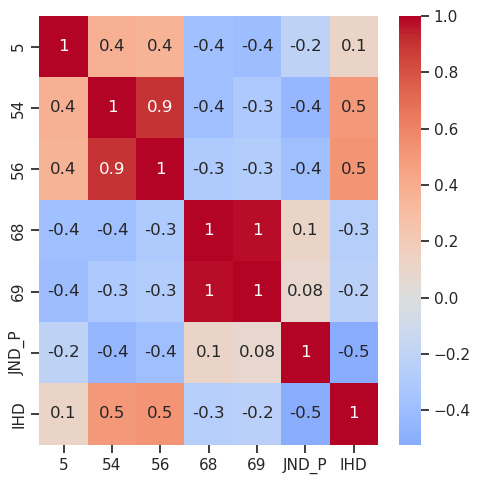

In [196]:

cont=dataready.columns
corr_matrix=pd.DataFrame(dataready[cont],columns=cont).corr()

fig, axes = plt.subplots(1, 1, figsize=(5, 5))#, sharey=True)

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.1g')
plt.tight_layout()

SCALING

In [198]:
X_df=dataready 

if psychophy==0:
    X_df=X_df.drop(['JND_P',], axis=1)
if fonctionalIHD==0:
    X_df=X_df.drop(['IHD',], axis=1)
    



## Scaling and KMEANS

testing quality of clustering 

In [200]:
#SCALING 
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X_df)
Xscaled_df = pd.DataFrame(Xscaled, columns=X_df.columns)
Xscaled_df.head()

,5,54,56,68,69
0,-0.904337,0.834965,0.746252,-1.034831,-0.830778
1,1.903469,0.183068,-0.782040,-1.191149,-1.141964
2,0.569925,0.892579,0.763454,-0.601186,-0.323947
3,2.779154,-0.346131,-0.050556,-0.571475,-0.754571
4,-0.010887,1.339487,1.476908,-0.314883,-0.279858


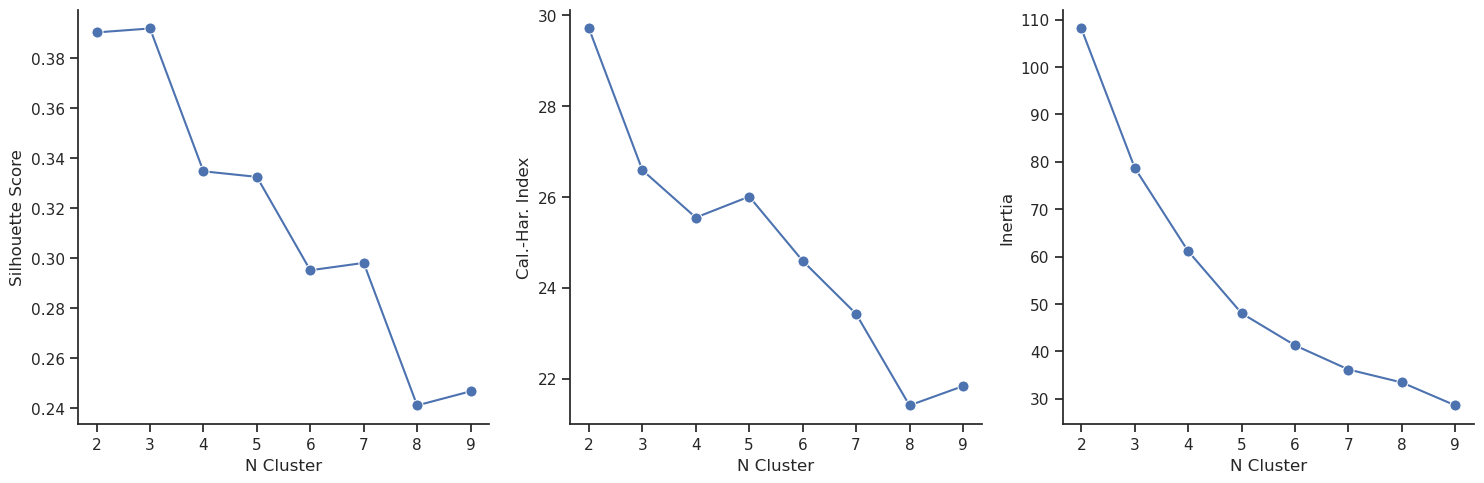

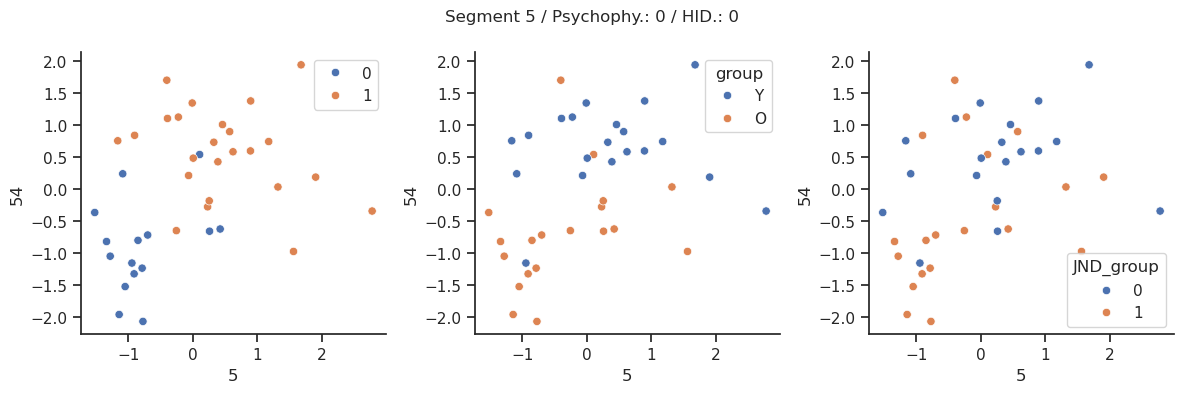

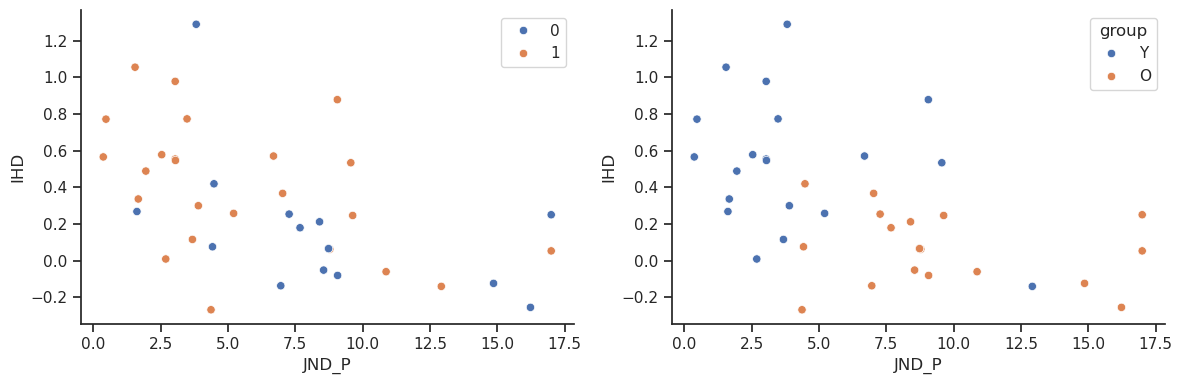

In [201]:
#KMEANS  
kmeans = KMeans(n_clusters=nclust, random_state=42).fit(Xscaled_df)
kmeans.labels_
CenterCluster=kmeans.cluster_centers_
labels_CC = kmeans.labels_


#AllSilScore,AllCalHar,Allinertia=[],[],[]

SilScore=[]
CalHar=[]
DavBouldin=[]
inertia=[]
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(Xscaled_df)
    SilScore.append(silhouette_score(Xscaled_df, kmeans.fit_predict(Xscaled_df)))
    CalHar.append(calinski_harabasz_score(Xscaled_df, kmeans.labels_))
    # DavBouldin.append(davies_bouldin_score(X, labels))
    inertia.append(kmeans.inertia_)  # Inertie (cohésion)

#AllSilScore.append(SilScore)
#AllCalHar.append(CalHar)
#Allinertia.append(inertia)

K_range = range(2, 10)  
    
df = pd.DataFrame({'Silhouette Score': SilScore,'Inertia': inertia,
               'Cal.-Har. Index': CalHar,'N Cluster': K_range})
df.head
sns.set_theme(style="ticks")



fig, axes = plt.subplots(1, 3, figsize=(15, 5))#, sharey=True)

sns.lineplot(ax=axes[0],data=df, y='Silhouette Score', x='N Cluster', marker='o',markersize=8)
sns.lineplot(ax=axes[1],data=df, x='N Cluster', y='Cal.-Har. Index', marker='o',markersize=8)
sns.lineplot(ax=axes[2],data=df, x='N Cluster', y='Inertia', marker='o',markersize=8)
axes[0].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
axes[2].spines[['right', 'top']].set_visible(False)
plt.tight_layout()


f1=SelectedFeat[0]
f2=SelectedFeat[1]


fig, axes = plt.subplots(1, 3, figsize=(12, 4))#, sharey=True)
fig.suptitle('Segment ' + str(CC)  + ' / Psychophy.: ' + str(psychophy) + ' / HID.: ' + str(fonctionalIHD), fontsize=12 )# or plt.suptitle('Main title')    
t=sns.scatterplot(ax=axes[1],data=Xscaled_df, x=f1, y=f2,hue=SubjectTable_imputed["group"]) 

sns.scatterplot(ax=axes[0],data=Xscaled_df, x=f1, y=f2,hue=labels_CC) 
sns.scatterplot(ax=axes[2],data=Xscaled_df, x=f1, y=f2,hue=SubjectTable_imputed["JND_group"]) 

axes[1].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].spines[['right', 'top']].set_visible(False)
axes[2].spines[['right', 'top']].set_visible(False)
axes[2].spines[['right', 'top']].set_visible(False)
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))#, sharey=True)

sns.scatterplot(ax=axes[0],data=Xscaled_df, x=SubjectTable_imputed["JND_P"], y=SubjectTable_imputed["IHD"],hue=labels_CC) 
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].spines[['right', 'top']].set_visible(False)

sns.scatterplot(ax=axes[1],data=Xscaled_df, x=SubjectTable_imputed["JND_P"], y=SubjectTable_imputed["IHD"],hue=SubjectTable_imputed["group"]) 
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
plt.tight_layout()

          5        54        56        68        69   age  JND_P       IHD  \
0  0.385030  0.627046  0.637671  0.440229  0.439572  25.0   9.56  0.534027   
1  0.520208  0.583707  0.546879  0.430411  0.420380  27.0   6.69  0.570600   
2  0.456006  0.630876  0.638693  0.467464  0.470830  28.0  12.92 -0.140120   
3  0.562367  0.548525  0.590335  0.469330  0.444272  21.0   1.95  0.488581   
4  0.428044  0.660587  0.681078  0.485445  0.473549  25.0   2.54  0.578001   

   group_O  group_Y group  JND_group  
0      0.0      1.0     Y          1  
1      0.0      1.0     Y          1  
2      0.0      1.0     Y          1  
3      0.0      1.0     Y          0  
4      0.0      1.0     Y          0  


/home/nicolascatz/anaconda3/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'truncate'
  cset = contour_func(
/home/nicolascatz/anaconda3/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'truncate'
  cset = contour_func(


    age  JND_P       IHD  group_O  group_Y group  JND_group  cluster
0  25.0   9.56  0.534027      0.0      1.0     Y          1        1
1  27.0   6.69  0.570600      0.0      1.0     Y          1        1
2  28.0  12.92 -0.140120      0.0      1.0     Y          1        1
3  21.0   1.95  0.488581      0.0      1.0     Y          0        1
4  25.0   2.54  0.578001      0.0      1.0     Y          0        1


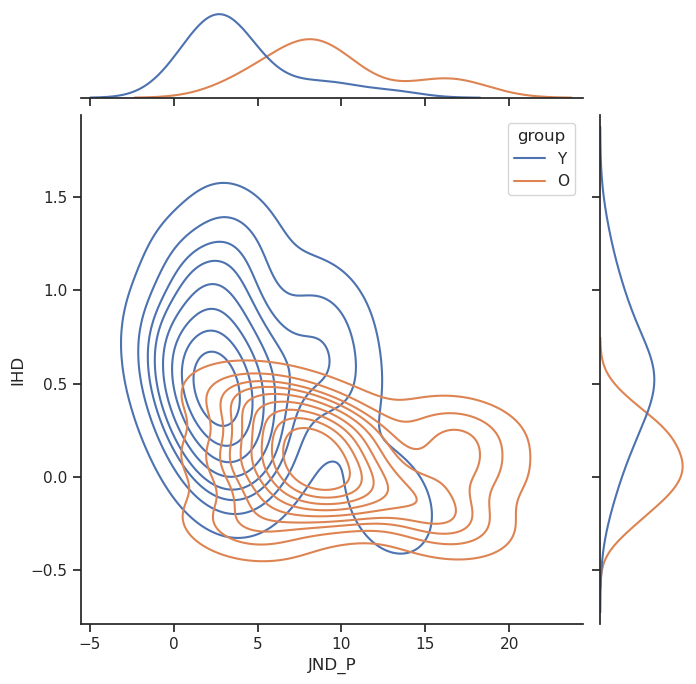

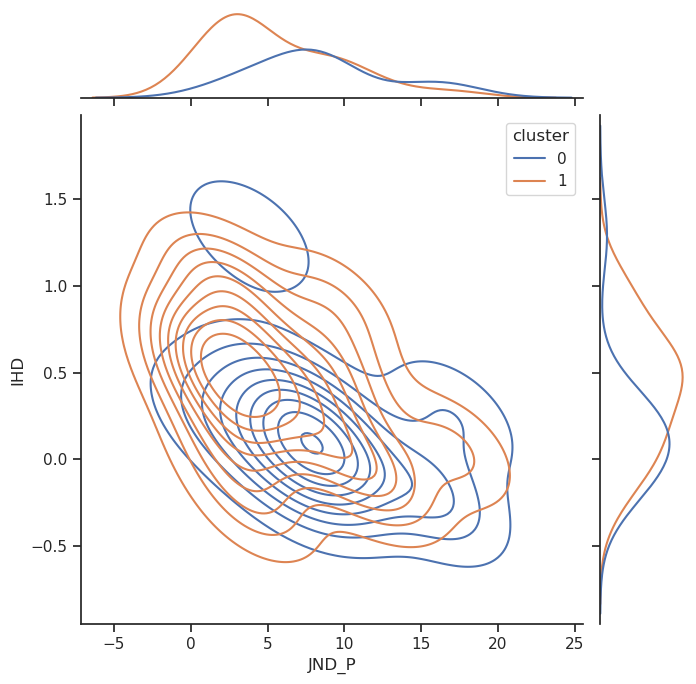

In [202]:
import seaborn as sns

sns.set_theme(style="ticks")

SubjectTable_imputed["group"]
print(data.head())

SubjectTable_imputed["cluster"]=labels_CC

g = sns.jointplot(x="JND_P", y="IHD", data=SubjectTable_imputed, kind="kde",hue="group", truncate=False,color="m", height=7)
g = sns.jointplot(x="JND_P", y="IHD", data=SubjectTable_imputed, kind="kde",hue="cluster", truncate=False,color="m", height=7)
print(SubjectTable_imputed.head())

### **Plot prediction of Age Groupe and JND from clusters**

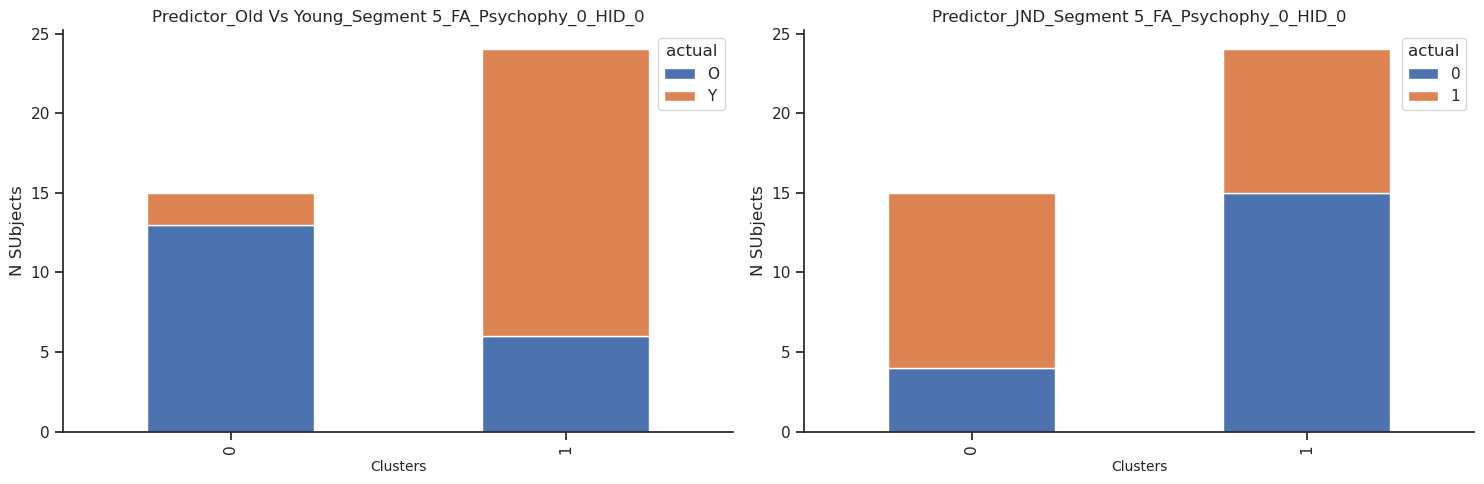

In [204]:

if psychophy==1:
    predicteur_list=['Old Vs Young']
else :
    predicteur_list=['Old Vs Young','JND']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))#, sharey=True)

for predicteurID in range(len(predicteur_list)):
    
    predicteur_str=predicteur_list[predicteurID]
    
    if predicteur_str=='JND':
            predicteur=JNDgroup
    elif predicteur_str=='Old Vs Young':
            predicteur=SubjectTable_imputed["group"]

    if predicteurID==0:
        a=0
    elif predicteurID==1:
        a =1

    df_clusters = pd.DataFrame({
    'actual': predicteur, 
    'predicted': labels_CC   
    })
     
    df_clusters = df_clusters.sort_values(by='predicted')
    
    group_distribution = pd.crosstab(df_clusters['predicted'], df_clusters['actual'])
     
    group_distribution.plot(ax=axes[a],kind='bar', stacked=True)
    
    axes[a].set_xlabel("Clusters", fontsize=10)
    axes[a].set_ylabel("N SUbjects", fontsize=12)
    axes[a].set_title('Predictor_' + predicteur_str+ '_Segment ' + str(CC)  + '_' + dti_metric + '_Psychophy_'
                   + str(psychophy) + '_HID_' + str(fonctionalIHD), fontsize=12)
    axes[a].spines['top'].set_visible(False)
    axes[a].spines['right'].set_visible(False)

   
plt.tight_layout()
    

#plt.savefig('Segment_' + str(CC) + '_' + dti_metric  + '_ Psychophy_' + str(psychophy) + '_ HID_' + 
#            str(fonctionalIHD)+'.eps', format='eps', bbox_inches="tight")

plt.show()

In [205]:
df_clusters.head()
X=X_df

now that we have identify that X clusters based on best features were detected and good predictor of group and JNP, let's train a **DecisionTree** supervised to verify

In order to find the best parameter to the model, **to avoid overfitting I used a HalvingGridSearchCV**


          5        54        56        68        69
0  0.385030  0.627046  0.637671  0.440229  0.439572
1  0.520208  0.583707  0.546879  0.430411  0.420380
2  0.456006  0.630876  0.638693  0.467464  0.470830
3  0.562367  0.548525  0.590335  0.469330  0.444272
4  0.428044  0.660587  0.681078  0.485445  0.473549
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



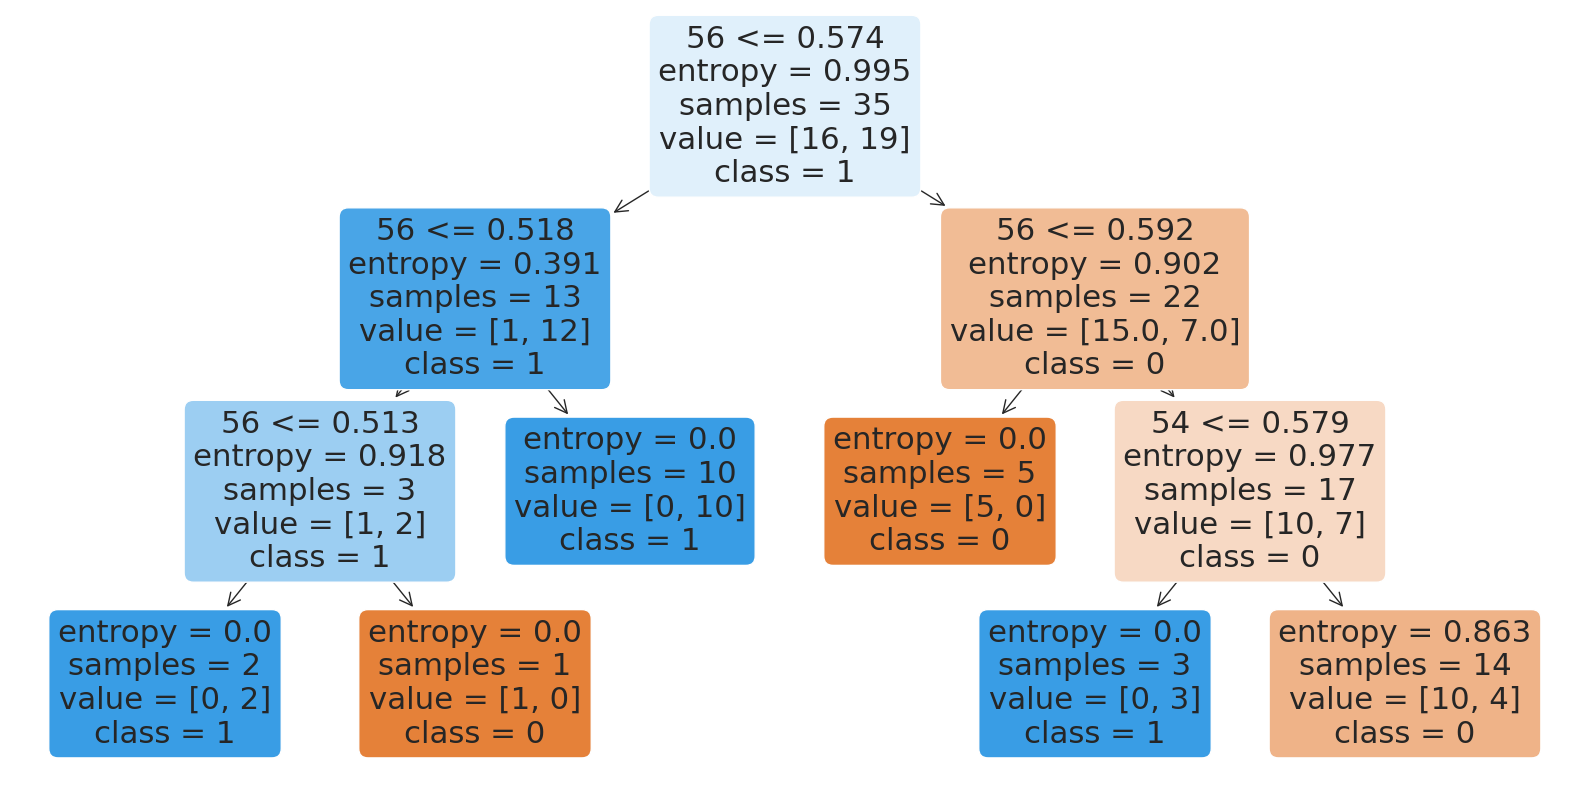

Confusion Matrix:
[[3 0]
 [0 1]]


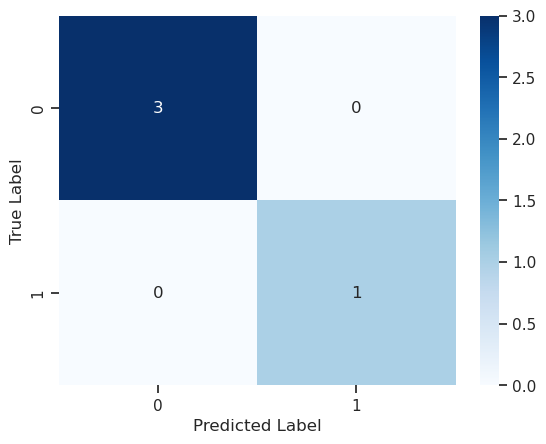

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Cross-Validation Accuracy Scores: [0.5        0.5        0.75       0.75       0.71428571]
Mean CV Accuracy: 0.6429


Text(0.5, 1.0, 'Learning Curve')

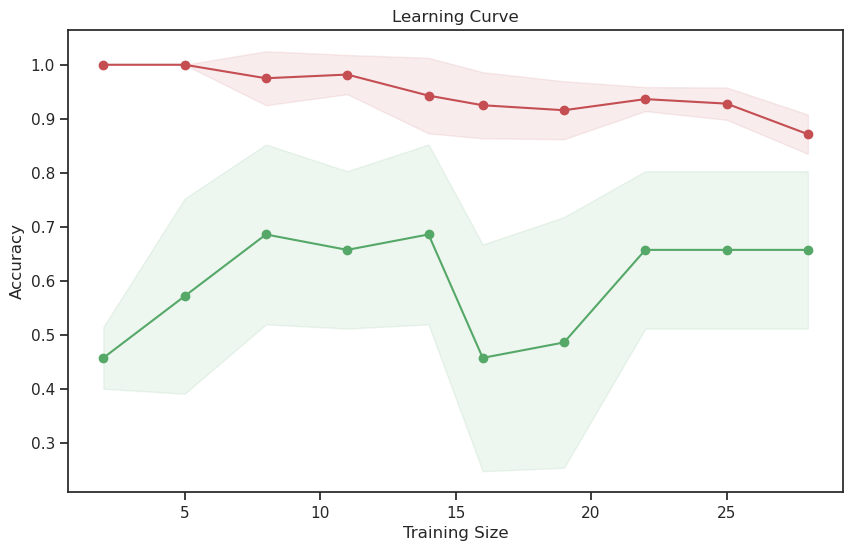

In [244]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, roc_auc_score)
from sklearn import tree
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print(X_df.head())

X=X_df
X_df.head()

targetVar=1

if targetVar==0:
    Y_group=data["group"] 
    targetnames=['Y','O']
    y=Y_group
if targetVar==1:
    Y_group=data["JND_group"] 
    targetnames=['0','1']   
    y=Y_group
if targetVar==2:
    Y_group=labels_CC
    targetnames=['0','1']   
    y=Y_group

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

param_grid = {'max_depth': [2,3,4 ,5, None],'splitter': ['best','random'],'criterion': ['gini', 'entropy'],"min_samples_split": [3,4,5]}

# Initialize the DecisionTreeClassifier and GridSearchCV
tree_clf = DecisionTreeClassifier(random_state=0)

grid_search = HalvingGridSearchCV(tree_clf, param_grid,random_state=0,factor=3, cv=5).fit(X_train, y_train)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the best estimator on the test data
y_pred = best_estimator.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot the best decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_estimator, filled=True, feature_names=X_df.columns, class_names=targetnames, rounded=True)
plt.show()
best_estimator

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualizing the Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))



from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_estimator, X, y, cv=5)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")

### **DECISION TREE LEARNING CURVE**


from sklearn.model_selection import learning_curve

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the model
#clf = DecisionTreeClassifier(random_state=42)

# Generate the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    best_estimator, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')